In [ ]:
import numpy as np
import pandas as pd
import re
import spacy
import en_core_web_sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import plot_confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import SVC 
from collections import Counter
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from keras.preprocessing import text, sequence

nlp = en_core_web_sm.load()

from textstat import syllable_count, flesch_reading_ease, dale_chall_readability_score
from pymagnitude import *
from tqdm import tqdm_notebook


In [2]:
def pre_proc(text):
    tokens = WordPunctTokenizer().tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [re.sub('[^a-zA-Z0-9\s]', '', token) for token in tokens]
    tokens = [token for token in tokens if token]
    tk = ' '.join(tokens) 
    tk = nlp(tk)
    tk = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in tk])
    return tk

In [3]:
# Plot non-normalized confusion matrix
def plot_cm(classifier, X_test, y_test):
    class_names = np.unique(y_test)
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

In [6]:
#import data
cdmp = pd.read_csv(r'psy 2018 cdmp r1.csv')
cdmp.CDMP_R1 = cdmp.CDMP_R1.astype('int64')
cdmp['text'] = cdmp['cdmptext'].apply(pre_proc)
xtrain_cdmp, xtest_cdmp, ytrain_cdmp, ytest_cdmp = train_test_split(cdmp.text,cdmp.CDMP_R1, 
                                                                    test_size=0.3, random_state=1008)



In [7]:
svm1_pp= imbpipeline([('tfvect',TfidfVectorizer()),
                     ('oversamp',RandomOverSampler(random_state=10023)),
                     ('svm',SVC(random_state=19039))])
svm1_pp_param= {'tfvect__stop_words': ['english',None],
               'tfvect__ngram_range':[(1,1),(1,2),(2,2),(1,3),(2,3),(3,3)],
               'tfvect__max_features': [500,700, 1000, 2000, 3000, 4000, 5000, 6000],
               'svm__kernel': ['linear','poly','rbf','sigmoid'],
               'svm__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'svm__tol':[0.0001,0.001,0.01,0.1,1,10,100,1000]}
svm1_gs = GridSearchCV(estimator = svm1_pp,
                      param_grid = svm1_pp_param,
                      scoring = make_scorer(kappa),
                      n_jobs=-1,
                     cv = 5)
#cdmp
svm1_gs = svm1_gs.fit(xtrain_cdmp,ytrain_cdmp)
print('CDMP: ', svm1_gs.best_score_)
print('CDMP: ', svm1_gs.best_params_)

CDMP:  0.5404941905626035
CDMP:  {'svm__C': 10, 'svm__kernel': 'rbf', 'svm__tol': 1, 'tfvect__max_features': 5000, 'tfvect__ngram_range': (1, 2), 'tfvect__stop_words': None}


QWK for cdmp (SVM1): 0.6003
Confusion matrix, without normalization
[[129  25]
 [ 33 105]]
Normalized confusion matrix
[[0.83766234 0.16233766]
 [0.23913043 0.76086957]]


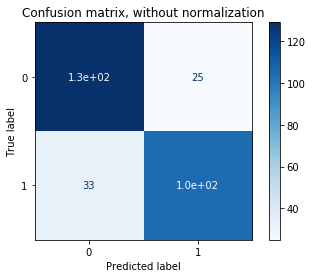

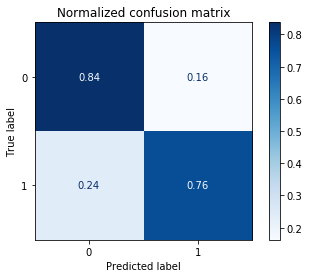

In [8]:
svm1_model = imbpipeline([('tfvect',TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words=None)),
                         ('oversamp',RandomOverSampler(random_state=10023)),
                     ('svm',SVC(C=10, kernel='rbf', tol=1, random_state=19039))])
svm1_model.fit(xtrain_cdmp,ytrain_cdmp)
svm1_pred = svm1_model.predict(xtest_cdmp)
svm1_kappa = kappa(svm1_pred,ytest_cdmp)
print('QWK for cdmp (SVM1):', round(svm1_kappa,4))
plot_cm(svm1_model,xtest_cdmp,ytest_cdmp)

## Use GloVe pre-trained model

In [11]:
# load the pre-trained word-vectors
embeddings_index = {}



f = open(r'glove.6B.200d.txt', encoding='utf8')
for line in f:
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:],dtype='float32')
f.close()

# create a tokenizer
token = text.Tokenizer()
token.fit_on_texts(cdmp['text'])
word_index = token.word_index 

# max length of text
max_len = max([len(s.split()) for s in xtrain_cdmp])

# convert text to sequence of tokens and pad them to ensure equal length vectors
tr_seq_x_cdmp = sequence.pad_sequences(token.texts_to_sequences(xtrain_cdmp), maxlen=max_len,padding='post')
te_seq_x_cdmp = sequence.pad_sequences(token.texts_to_sequences(xtest_cdmp), maxlen=max_len, padding='post')

#create token-embedding mapping
embedding_matrix = np.zeros((len(word_index)+1,200))
for w, i in word_index.items():
    embedding_vector = embeddings_index.get(w)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
# create text to vector

def txt2vec(text):
    M = []
    for w in WordPunctTokenizer().tokenize(text):
        if not w.isalpha():
            continue
        if w in embeddings_index:
            M.append(embeddings_index[w])
    M = np.array(M)
    v = M.mean(axis=0)
    if type(v)!= np.ndarray:
        return np.zeros(200)
    return v

In [13]:
tr_pt_x_cdmp = np.array([txt2vec(s) for s in xtrain_cdmp])
te_pt_x_cdmp = np.array([txt2vec(s) for s in xtest_cdmp])

In [14]:
svm1_pt = imbpipeline([('oversamp', RandomOverSampler(random_state=10023)),
                      ('svm', SVC(random_state=19039))])

svm1_pt_param= {'svm__kernel': ['linear','poly','rbf','sigmoid'],
               'svm__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'svm__tol':[0.0001,0.001,0.01,0.1,1,10,100,1000]}

svm1_pt_gs = GridSearchCV(estimator = svm1_pt,
                      param_grid = svm1_pt_param,
                      scoring = make_scorer(kappa),
                      n_jobs=-1,
                     cv = 5)
#cdmp
svm1_pt_gs = svm1_pt_gs.fit(tr_pt_x_cdmp,ytrain_cdmp)
print('CDMP (svm pretrained): ', svm1_pt_gs.best_score_)
print('CDMP (svm pretrained): ', svm1_pt_gs.best_params_)

CDMP (svm pretrained):  0.5387140673174218
CDMP (svm pretrained):  {'svm__C': 100, 'svm__kernel': 'rbf', 'svm__tol': 0.1}


QWK for cdmp (svm1 pretrained):  0.5945
Confusion matrix, without normalization
[[125  29]
 [ 30 108]]
Normalized confusion matrix
[[0.81168831 0.18831169]
 [0.2173913  0.7826087 ]]


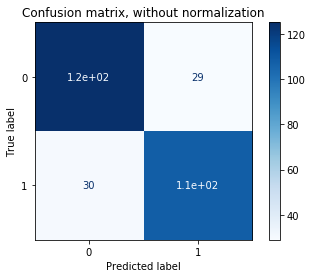

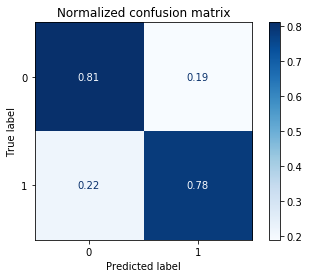

In [15]:
svm1_pt_pred = svm1_pt_gs.predict(te_pt_x_cdmp)
svm1_pt_kappa = kappa(svm1_pt_pred,ytest_cdmp)
print('QWK for cdmp (svm1 pretrained): ', round(svm1_pt_kappa,4))
plot_cm(svm1_pt_gs, te_pt_x_cdmp,ytest_cdmp)

## Feature engineering

In [16]:
def num_of_word(x,y,K):
    x['num_word'] = x['text'].apply(lambda x: len(x.split()))
    plt.figure()
    for k in range(K):
        xx = x[x[y]==k]
        sns.distplot(xx['num_word'], hist=True, rug=True, kde_kws={'linewidth': 3}, label=k)
    plt.legend(prop={'size': 16}, title = 'Scores')
    plt.title('Distribution of number of words ' + y[:-3])
    plt.xlabel('Number of Words')
    plt.ylabel('Density')

    return x

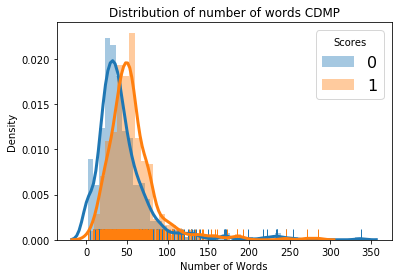

In [19]:
cdmp = num_of_word(cdmp,'CDMP_R1',2)

In [20]:
def mean_word_len(x,y,K):
    x['mean_w_len'] = x['text'].apply(lambda x: sum(len(w) for w in x.split())/len(x.split()))
    plt.figure()
    for k in range(K):
        xx = x[x[y]==k]
        sns.distplot(xx['mean_w_len'], hist=True, rug=True, kde_kws={'linewidth': 3}, label=k)
    plt.legend(prop={'size': 16}, title = 'Scores')
    plt.title('Distribution of mean word length ' + y[:-3])
    plt.xlabel('Mean Word Length')
    plt.ylabel('Density')

    return x

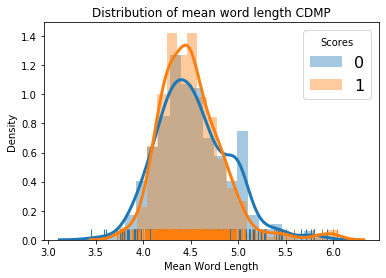

In [21]:
cdmp = mean_word_len(cdmp,'CDMP_R1',2)

In [22]:
def stopword_r(x,y,K):
    stop_words = stopwords.words('english')
    x['stopword_r'] = x['text'].apply(lambda x: len([w for w in x.split() if w in stop_words])/len(x.split()))
    plt.figure()
    for k in range(K):
        xx = x[x[y]==k]
        sns.distplot(xx['stopword_r'], hist=True, rug=True, kde_kws={'linewidth': 3}, label=k)
    plt.legend(prop={'size': 16}, title = 'Scores')
    plt.title('Distribution of stopword ratio ' + y[:-3])
    plt.xlabel('Stopword ratio')
    plt.ylabel('Density')

    return x

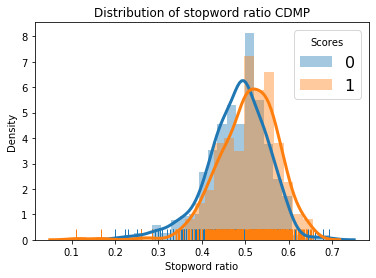

In [23]:
cdmp = stopword_r(cdmp,'CDMP_R1',2)

In [24]:
def mean_syl(x,y,K):
    x['mean_syl'] = x['text'].apply(lambda x: sum(syllable_count(w) for w in x.split())/len(x.split()))
    plt.figure()
    for k in range(K):
        xx = x[x[y]==k]
        sns.distplot(xx['mean_syl'], hist=True, rug=True, kde_kws={'linewidth': 3}, label=k)
    plt.legend(prop={'size': 16}, title = 'Scores')
    plt.title('Distribution of mean number of syllables per word ' + y[:-3])
    plt.xlabel('Mean Number of Syllable per Word')
    plt.ylabel('Density')

    return x

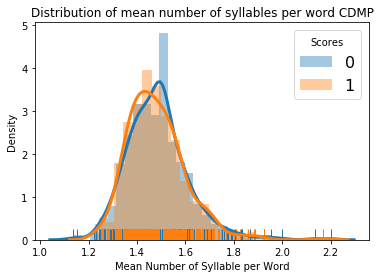

In [27]:
cdmp = mean_syl(cdmp,'CDMP_R1',2)

In [28]:
def flesch(x,y,K):
    x['flesch'] = x['text'].apply(lambda x: flesch_reading_ease(x))
    plt.figure()
    for k in range(K):
        xx = x[x[y]==k]
        sns.distplot(xx['flesch'], hist=True, rug=True, kde_kws={'linewidth': 3}, label=k)
    plt.legend(prop={'size': 16}, title = 'Scores')
    plt.title('Distribution of Flesch reading ease score ' + y[:-3])
    plt.xlabel('Flesch Reading Ease Score')
    plt.ylabel('Density')

    return x

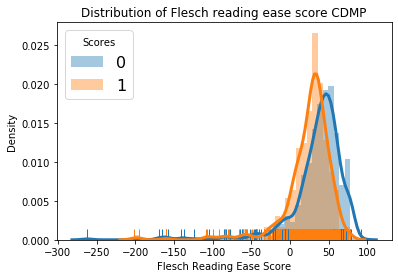

In [29]:
cdmp = flesch(cdmp,'CDMP_R1',2)

In [30]:
def dale(x,y,K):
    x['dale'] = x['text'].apply(lambda x: dale_chall_readability_score(x))
    plt.figure()
    for k in range(K):
        xx = x[x[y]==k]
        sns.distplot(xx['dale'], hist=True, rug=True, kde_kws={'linewidth': 3}, label=k)
    plt.legend(prop={'size': 16}, title = 'Scores')
    plt.title('Distribution of Dale-Chall readability score ' + y[:-3])
    plt.xlabel('Dale-Chall Readability Score')
    plt.ylabel('Density')

    return x

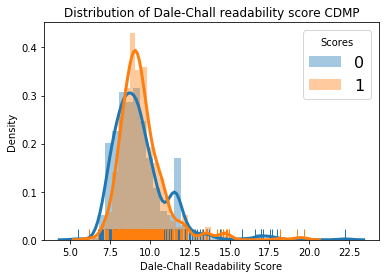

In [31]:
cdmp = dale(cdmp,'CDMP_R1',2)

In [32]:
xtrain_cdmp, xtest_cdmp, ytrain_cdmp, ytest_cdmp = train_test_split(cdmp.iloc[:,1:],cdmp.CDMP_R1, 
                                                                    test_size=0.3, random_state=1008)

In [33]:
xtrain_cdmp1=xtrain_cdmp.sort_index(axis=0).reset_index(drop=True)
ytrain_cdmp1=ytrain_cdmp.sort_index(axis=0).reset_index(drop=True)
xtest_cdmp1 = xtest_cdmp.sort_index(axis=0).reset_index(drop=True)
ytest_cdmp1 = ytest_cdmp.sort_index(axis=0).reset_index(drop=True)

## Magnitude glove 200d avg_glove

In [39]:
glove = Magnitude(r"glove.6B.200d.magnitude")

def avg_glove(df):
    df1 = df.sort_index(axis=0).reset_index(drop=True)
    vectors = []
    for txt in tqdm_notebook(df1.text.values):
        vectors.append(np.average(glove.query(WordPunctTokenizer().tokenize(txt)), axis = 0))
    return np.array(vectors)

glxtr_cdmp_avg = avg_glove(xtrain_cdmp)
glxte_cdmp_avg = avg_glove(xtest_cdmp)

In [48]:
scaler = StandardScaler()
dfgltr_cdmp_avg = pd.DataFrame(data = glxtr_cdmp_avg[0:,0:],
                              index = [i for i in range(glxtr_cdmp_avg.shape[0])],
                              columns = ['glove'+str(i) for i in range(glxtr_cdmp_avg.shape[1])])
dfgltr_cdmp_avg0 = pd.concat([xtrain_cdmp1, dfgltr_cdmp_avg.reset_index(drop=True)],axis=1, ignore_index=True)
head =  list(xtrain_cdmp1.columns) + list(dfgltr_cdmp_avg.columns)
dfgltr_cdmp_avg0.columns = head
dfgltr_cdmp_avg0 = dfgltr_cdmp_avg0.iloc[:,3:]
dfgltr_cdmp_avg00 = scaler.fit_transform(dfgltr_cdmp_avg0)

dfglte_cdmp_avg = pd.DataFrame(data = glxte_cdmp_avg[0:,0:],
                              index = [i for i in range(glxte_cdmp_avg.shape[0])],
                              columns = ['glove'+str(i) for i in range(glxte_cdmp_avg.shape[1])])
dfglte_cdmp_avg0 = pd.concat([xtest_cdmp1, dfglte_cdmp_avg.reset_index(drop=True)],axis=1, ignore_index=True)
dfglte_cdmp_avg0.columns = head
dfglte_cdmp_avg0 = dfglte_cdmp_avg0.iloc[:,3:]
dfglte_cdmp_avg00 = scaler.transform(dfglte_cdmp_avg0)

In [49]:
svm1_pt = SVC(random_state=19039)

svc_param= {'kernel': ['linear','sigmoid','rbf','poly'],
            'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'tol':[0.0001,0.001,0.01,0.1,1,10,100,1000]}
svc_gs1 = GridSearchCV(estimator = svm1_pt,
                      param_grid = svc_param,
                      scoring = make_scorer(kappa),
                      n_jobs=-1,
                      cv = 5)
svc_gs1 = svc_gs1.fit(dfgltr_cdmp_avg00,ytrain_cdmp1)
print('CDMP (svm pretrained): ', svc_gs1.best_score_)
print('CDMP (svm pretrained): ', svc_gs1.best_params_)

CDMP (svm pretrained):  0.47456078703728954
CDMP (svm pretrained):  {'C': 1, 'kernel': 'rbf', 'tol': 0.1}


QWK for cdmp (svm2 pretrained):  0.5597
Confusion matrix, without normalization
[[124  30]
 [ 34 104]]
Normalized confusion matrix
[[0.80519481 0.19480519]
 [0.24637681 0.75362319]]


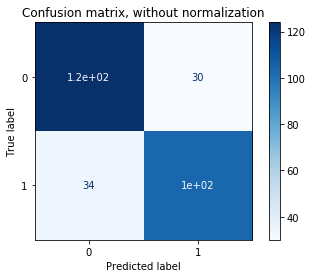

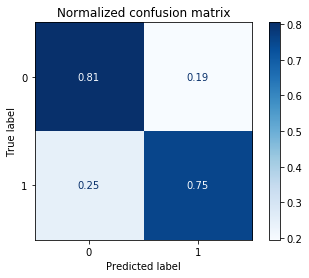

In [50]:
svc_gs1_pred = svc_gs1.predict(dfglte_cdmp_avg00)
svc_gs1_kappa = kappa(svc_gs1_pred,ytest_cdmp1)
print('QWK for cdmp (svm2 pretrained): ', round(svc_gs1_kappa,4))
plot_cm(svc_gs1, dfglte_cdmp_avg00,ytest_cdmp1)